In [ ]:
import numpy as np
import pandas as pd
import umap
import sklearn.decomposition
import sklearn.svm, sklearn.linear_model
import sklearn.metrics, sklearn.preprocessing

import os
import tqdm
import pysam
import matplotlib.pyplot as plt

from src import Selector

selector = Selector("data/feature")

chromosome_list = [str(i) for i in range(1, 23)] + ["X"]

# Prediction

In [52]:
# read profile
profile = pd.read_csv("data/profile.csv")
profile = profile[profile["dataset"] == "tcgaskcm"]
profile = pd.concat([
    profile[profile["easy"] == 1], profile[profile["hard"] == 1]
]).reset_index(drop=True)
# random sample train, valid, test using pandas sample
profile_train = profile.sample(frac=0.6, random_state=0)
profile_valid = profile.drop(profile_train.index).sample(frac=0.5, random_state=0)
profile_test  = profile.drop(profile_train.index).drop(profile_valid.index)

#profile_train = profile[profile["train"] == 1]
#profile_valid = profile[profile["valid"] == 1]
#profile_test  = profile[profile["test"]  == 1]
# representation
repre_train = selector.getRepre(profile_train["embd_fold"].to_list(), recalculate=False)   # (497, 768)
repre_valid = selector.getRepre(profile_valid["embd_fold"].to_list(), recalculate=False)   # (216, 768)
repre_test  = selector.getRepre(profile_test["embd_fold"].to_list(), recalculate=False)    # (215, 768)
repre = np.vstack([repre_train, repre_valid, repre_test])               # (928, 768)
# PCA
pca = sklearn.decomposition.PCA()
pca = pca.fit(repre)
repre_train = pca.transform(repre_train)    # (497, 768)
repre_valid = pca.transform(repre_valid)    # (216, 768)
repre_test  = pca.transform(repre_test)     # (215, 768)

getRepre: 100%|██████████| 185/185 [00:01<00:00, 152.71sample/s]


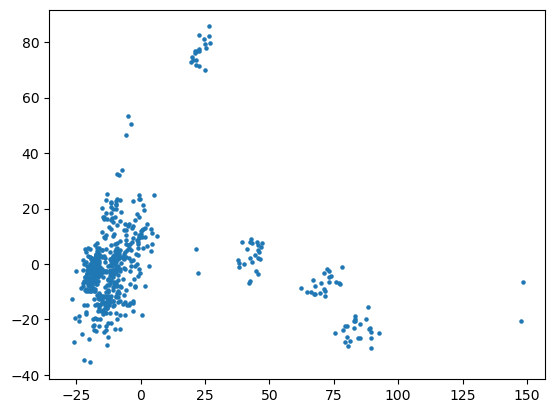

In [53]:
plt.scatter(repre_train[:, 0], repre_train[:, 1], s=5)
plt.show()

In [54]:
start, end = 0, 100
t1, t2 = 0.4, 0.6

train mae: 0.136
valid mae: 0.167
[[403  17   0]
 [ 92  11   0]
 [ 26   8   0]]
[[126  12   0]
 [ 36   3   0]
 [  7   2   0]]
train accuracy: 0.743
valid accuracy: 0.694


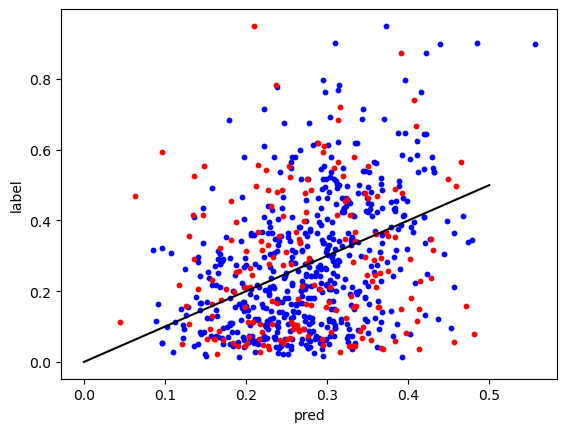

In [55]:
## T Cells CD8
# label
label_train = profile_train["Leukocyte Fraction"]
label_valid = profile_valid["Leukocyte Fraction"]
label_test  = profile_test ["Leukocyte Fraction"]
# prediction
model = sklearn.linear_model.LinearRegression().fit(repre_train[:, start:end], label_train)
#model = sklearn.svm.SVR().fit(repre_train[:, start:end], label_train)
pred_train = model.predict(repre_train[:, start:end])
pred_valid = model.predict(repre_valid[:, start:end])
pred_test  = model.predict(repre_test[:, start:end])
# performance
mae_train = sklearn.metrics.mean_absolute_error(label_train, pred_train)
mae_valid = sklearn.metrics.mean_absolute_error(label_valid, pred_valid)
print(f"train mae: {mae_train:.3f}")
print(f"valid mae: {mae_valid:.3f}")
# view T Cells CD8 < 0.1 as low, 0.1 <= T Cells CD8 < 0.3 as middle, 
# 0.3 <= T Cells CD8 as high, check pred_valid and profile_valid["T Cells CD8"]
# performance in classification way
label_class_train = np.digitize(label_train, [t1, t2])
label_class_valid = np.digitize(label_valid, [t1, t2])
pred_class_train = np.digitize(pred_train, [t1, t2])
pred_class_valid = np.digitize(pred_valid, [t1, t2])
# 3 * 3 confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(label_class_train, pred_class_train)
print(confusion_matrix)
confusion_matrix = sklearn.metrics.confusion_matrix(label_class_valid, pred_class_valid)
print(confusion_matrix)
# print accuracy
accuracy_train = sklearn.metrics.accuracy_score(label_class_train, pred_class_train)
accuracy_valid = sklearn.metrics.accuracy_score(label_class_valid, pred_class_valid)
print(f"train accuracy: {accuracy_train:.3f}")
print(f"valid accuracy: {accuracy_valid:.3f}")

# plot pred_valid as x and label_valid as y
plt.scatter(pred_train, label_train, color="blue", s=10)
plt.scatter(pred_valid, label_valid, color="red", s=10)
plt.plot([0, 0.5], [0, 0.5], color="black")
plt.xlabel("pred")
plt.ylabel("label")
plt.show()

In [ ]:
# TODO: prediction using Th2 Cells as lable and svm as model
svm = sklearn.svm.SVR().fit(repre_train, profile_train["Th2 Cells"])
pred_train = svm.predict(repre_train)
pred_valid = svm.predict(repre_valid)
mae_train = sklearn.metrics.mean_absolute_error(profile_train["Th2 Cells"], pred_train)
mae_valid = sklearn.metrics.mean_absolute_error(profile_valid["Th2 Cells"], pred_valid)
print(f"train mae: {mae_train:.2f}")
print(f"valid mae: {mae_valid:.2f}")

# Visulization

In [ ]:
# profile 0: nan to 0
# profile 1: remove nan row

# representation
profile = pd.read_csv("data/profile0.csv")
profile = profile.iloc[23:].reset_index(drop=True)
repre = np.hstack([
    np.load(profile.loc[i, "repre_path"]) for i in range(len(profile))
    if not pd.isna(profile.loc[i, "repre_path"])
]).T
# for each column, if there are np.nan in that column, drop that column
repre = repre[:, np.all(~np.isnan(repre), axis=0)]  # comment for 0, un for 1
repre = np.nan_to_num(repre, nan=0.0)
# fit
visu_pca = sklearn.decomposition.PCA(n_components=8).fit(repre)
visu_umap = umap.UMAP(n_components=3).fit(repre)
# transform
idx = [
    i for i in range(len(profile)) if not pd.isna(profile.loc[i, "repre_path"])
]
profile.loc[idx, [f"pca{p}" for p in range(8)]] = visu_pca.transform(repre)
profile.loc[idx, [f"umap{u}" for u in range(3)]] = visu_umap.transform(repre)
# save
profile.to_csv("data/profile2.csv", index=False)

# Profile

In [ ]:
# { chromosome : (hash_idx, bucket_idx, distance) }
feature = Selector("data/feature").getFeature()
# remove distance and ndarray dtype from float to int
# { chromosome : (hash_idx, bucket_idx) }
feature = {c: np.array([f[:2] for f in feature[c]], dtype=int) for c in feature}
result = []
for c in chromosome_list:
    for hash_idx, bucket_idx in feature[c]:
        result.append((c, hash_idx*1000 + bucket_idx*100, hash_idx*1000 + (bucket_idx+1)*100))
result = pd.DataFrame(result, columns=["chromosome", "start", "end"])
result.to_csv("data/temp/feature.csv", index=False)

In [ ]:
hash_idx_max = {
    "1": 249000,  "2": 243000,  "3": 199000,  "4": 191000,
    "5": 182000,  "6": 171000,  "7": 160000,  "8": 146000,
    "9": 139000, "10": 134000, "11": 136000, "12": 134000,
    "13": 115000, "14": 108000, "15": 102000, "16":  91000,
    "17":  84000, "18":  81000, "19":  59000, "20":  65000,
    "21":  47000, "22":  51000,  "X": 157000,
}

## bed
# read bed file
bed = pd.read_csv(
    "data/temp/rgc_gxs_v1_hg38.bed", 
    sep="\t", header=0, names=["chromosome", "start", "end"]
)
# remove chr prefix
bed["chromosome"] = bed["chromosome"].apply(lambda x: x[3:])
# keep chromosome 1-22 and X
bed = bed[bed['chromosome'].isin(chromosome_list)]
# transform bed from range list to one hot
bed_one_hot = {
    c: np.zeros((hash_idx_max[c] * 1000), dtype=bool) for c in chromosome_list
}
for _, row in bed.iterrows():
    chromosome, start, end = row[['chromosome', 'start', 'end']]
    bed_one_hot[chromosome][start:end] = True

## feature
# { chromosome : (hash_idx, bucket_idx, distance) }
feature = Selector("data/feature").getFeature()
# remove distance and ndarray dtype from float to int
# { chromosome : (hash_idx, bucket_idx) }
feature = {c: np.array([f[:2] for f in feature[c]], dtype=int) for c in feature}
# transform feature from bucket list to one hot
feature_one_hot = {
    c: np.zeros((hash_idx_max[c] * 1000), dtype=bool) for c in chromosome_list
}
for c in feature:
    for hash_idx, bucket_idx in feature[c]:
        feature_one_hot[c][
            hash_idx*1000 + bucket_idx*100 : hash_idx*1000 + (bucket_idx+1)*100
        ] = True

# calculate overlap
for c in bed_one_hot:
    overlap = np.logical_and(bed_one_hot[c], feature_one_hot[c])
    overlap_bed = (np.sum(overlap) / np.sum(bed_one_hot[c])) * 100 
    overlap_feature = (np.sum(overlap) / np.sum(feature_one_hot[c])) * 100
    print(
        f"Chromosome {c}:\t",
        f"overlap/bed: {np.sum(overlap):7,} / {np.sum(bed_one_hot[c]):9,} = {overlap_bed:5.2f}%\t",
        f"overlap/feature: {np.sum(overlap):7,} / {np.sum(feature_one_hot[c]):9,} = {overlap_feature:5.2f}%"
    )

In [ ]:
p_val = 1e-3

snps = pd.read_csv("data/snps.csv", usecols=["Chr", "Pos", "Pval"])
# filter by pval < 1e-3
snps = snps[snps["Pval"] < p_val][["Chr", "Pos"]]
# sort by Chr and then Pos
snps = snps.sort_values(["Chr", "Pos"])
# transform chromosome from int 1-23 to str 1-22, X
snps["Chr"] = snps["Chr"].apply(lambda x: str(x) if x < 23 else "X")
# split by chromosome, { chromosome : (pos) }
snps = snps.groupby("Chr")["Pos"].apply(list).to_dict()

for c, pos in snps.items():
    snps_in_bed, snps_in_feature = 0, 0
    for p in pos:
        if bed_one_hot[c][p]: snps_in_bed += 1
        if feature_one_hot[c][p]: snps_in_feature += 1
    print(
        f"Chromosome {c}:\t",
        f"snps_in_bed/bed: {snps_in_bed:6,} / {len(pos):6,} = {(snps_in_bed / len(pos)) * 100:5.2f}%\t",
        f"snps_in_feature/feature: {snps_in_feature:6,} / {len(pos):6,} = {(snps_in_feature / len(pos)) * 100:5.2f}%"
    )

In [ ]:
p_val = 1e-2

snps = pd.read_csv("data/snps.csv", usecols=["Chr", "Pos", "Pval"])
# filter by pval < 1e-2
snps = snps[snps["Pval"] < p_val][["Chr", "Pos"]]
# sort by Chr and then Pos
snps = snps.sort_values(["Chr", "Pos"])
# transform chromosome from int 1-23 to str 1-22, X
snps["Chr"] = snps["Chr"].apply(lambda x: str(x) if x < 23 else "X")
# split by chromosome, { chromosome : (pos) }
snps = snps.groupby("Chr")["Pos"].apply(list).to_dict()

for c, pos in snps.items():
    snps_in_bed, snps_in_feature = 0, 0
    for p in pos:
        if bed_one_hot[c][p]: snps_in_bed += 1
        if feature_one_hot[c][p]: snps_in_feature += 1
    print(
        f"Chromosome {c}:\t",
        f"snps_in_bed/bed: {snps_in_bed:7,} / {len(pos):7,} = {(snps_in_bed / len(pos)) * 100:5.2f}%\t",
        f"snps_in_feature/feature: {snps_in_feature:7,} / {len(pos):7,} = {(snps_in_feature / len(pos)) * 100:5.2f}%"
    )

# Example

In [ ]:
## BAM and SNPs to Sequence

import pandas as pd

# read hdf of given sample and chromosome
hdf_path = "temp/hdf/a.h5"
chromosome = "2"
hdf = pd.read_hdf(hdf_path, key=f"/chr{chromosome}", mode='r')
# filter reads that cover at least one variants with p-value<pval_thresh
#pval_thresh = 1e-1
#hdf = hdf[hdf[f"{pval_thresh:.0e}"]>=1]
# glace
print(f"number of reads in {hdf_path}/chr{chromosome}: {len(hdf)}")
display(hdf.head())
display(hdf.tail())

In [ ]:
## Sequence to Embedding
import numpy as np
a = np.load("temp/instance/embd/a/2/000/016.npy")
print(a[:, 768])
a = np.load("temp/instance/embd/a/2/000/017.npy")
print(a[:, 768])

In [ ]:
## Add Feature (sample_idx, pos, embd_idx, distance)

import numpy as np
import os
from src.embd2repre import Selector

#selector = Selector("temp/instance/feature")
#selector.addFeature(["temp/instance/embd/a", "temp/instance/embd/b"], chromosome="2")
#selector.addFeature(["temp/instance/embd/c"], chromosome="2")

print("feature 2/000/010")
print(np.load("temp/instance/feature/2/000/010.npy")[:, 0])
print(np.load("temp/instance/feature/2/000/010.npy")[:, 1])
print("sample a/2/000/010")
print(np.load("temp/instance/embd/a/2/000/010.npy")[:, 768])
print("sample b/2/000/010")
print(np.load("temp/instance/embd/b/2/000/010.npy")[:, 768])
print("sample c/2/000/010")
print(np.load("temp/instance/embd/c/2/000/010.npy")[:, 768])
print("feature 2/000/010")
print(np.load("temp/instance/feature/2/000/010.npy")[:, 0])
print(np.load("temp/instance/feature/2/000/010.npy")[:, 1])

In [ ]:
## getFeature { chromosome : (hash_idx, bucket_idx, distance) }

from src.embd2repre import Selector

selector = Selector("temp/feature")
feature_c = selector.getFeature(chromosome="2")["2"]

print(feature_c.shape)
print("hash_idx, bucket_idx, distance")
print(feature_c[:10])

top_k = 0.15
top_k = int(len(feature_c) * top_k)
order = np.sort(np.argsort(feature_c[:, 2])[-top_k:])
feature_c = feature_c[order]

print("after select top 15% of feature")
print("hash_idx, bucket_idx, distance")
print(feature_c)

In [ ]:
## applyFeature (:768 embd, 768 pos, 769 embd_idx)

from src.embd2repre import Selector

selector = Selector("temp/feature")
selector.applyFeature(["temp/embd/a", "temp/embd/b", "temp/embd/c"], chromosome="2")

feature = np.load("temp/embd/a/2/feature.npy")
print(feature[:, 768])
print(feature.shape)